In [2]:
# Import custom helper libraries
import os
import sys

# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# System modules
import time
import random
import requests
from hashlib import md5
import json


# ML modules
import pandas as pd
import numpy as np
import seaborn as sns

from utils import *

import string

# Sample data for development
TEXT_SAMPLE_SIZE = 10 * 1000  # <= 0 for all
PHOTO_SAMPLE_SIZE = 20 * 1000  # <= 0 for all

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [242]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/bartcus/nltk_data...


True

In [3]:
import spacy
# Download SpaCy model
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 2.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
nlp = spacy.load("en_core_web_sm")

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bartcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bartcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def reduce_dataframe_memory_usage(df, high_precision = False):
    """
    Iterate through all the columns of a dataframe and modify the data type to
    reduce memory usage.
    Args:
        df (pd.DataFrame): dataframe to reduce memory usage.
        high_precision (bool): If True, use 64-bit floats instead of 32-bit
    Returns:
        pd.DataFrame: dataframe with reduced memory usage.
    """
    start_mem = round(df.memory_usage().sum() / 1024 ** 2, 2)
    logging.info("Memory usage of dataframe is %d MB", start_mem)

    # Iterate through columns
    for col in df.columns:
        if df[col].dtype == "object":
            # "object" dtype
            if df[col].nunique() < max(100, df.shape[0] / 100):
                # If number of unique values is less than max(100, 1%)
                df[col] = df[col].astype("category")
            else:
                # If number of unique values is greater than max(100, 1%)
                df[col] = df[col].astype("string")

        elif str(df[col].dtype)[:3] == "int":
            # "int" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df[col] = df[col].astype("UInt8")
            elif c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype("Int8")
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df[col] = df[col].astype("UInt16")
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype("Int16")
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df[col] = df[col].astype("UInt32")
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype("Int32")
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                df[col] = df[col].astype("UInt64")
            else:
                df[col] = df[col].astype("Int64")

        elif str(df[col].dtype)[:5] == "float":
            # "float" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if (
                not high_precision
                and c_min > np.finfo(np.float32).min
                and c_max < np.finfo(np.float32).max
            ):
                df[col] = df[col].astype("float32")
            else:
                df[col] = df[col].astype("float64")

    end_mem = round(df.memory_usage().sum() / 1024 ** 2, 2)
    logging.info("Memory usage after optimization is %d MB", end_mem)
    if start_mem > 0:
        logging.info(
            "Decreased by %d %%", round(100 * (start_mem - end_mem) / start_mem)
        )

    return df

# Review dataset

In [6]:
if os.path.exists("data/processed/reviews.pkl.gz"):
    # Load academic data from pickle file
    logger.info(">>> Loading reviews from pickle file...")
    reviews_df = pd.read_pickle("data/processed/reviews.pkl.gz")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from pickle file.")
else:
    # Load academic data from row CSV file
    logger.info(">>> Loading reviews from JSON file...")
    reviews_df = pd.DataFrame()
    with pd.read_json(
        "data/yelp_dataset/yelp_academic_dataset_review.json",
        dtype={
            "review_id": str,
            "user_id": str,
            "business_id": str,
            "stars": int,
            "useful": int,
            "funny": int,
            "cool": int,
            "text": str,
            "date": "datetime64[ns]",
        },
        chunksize=500 * 1000,
        lines=True,
    ) as json_reader:
        # Load data in chunks
        for chunk in json_reader:
            reviews_df = reviews_df.append(chunk)
            logger.info(f"Loaded {len(reviews_df)} reviews")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from JSON file.")

    # Reduce memory usage
    reviews_df = reduce_dataframe_memory_usage(reviews_df)

    # Save as pickle
    logger.info(">>> Saving reviews data as pickle file...")
    os.makedirs("data/processed/", exist_ok=True)
    reviews_df.to_pickle("data/processed/reviews.pkl.gz")
    logger.info(
        ">>> OK : Reviews data saved to data/processed/reviews.pkl.gz ."
    )

if TEXT_SAMPLE_SIZE > 0:
    # Sample data
    logger.info(">>> Sampling reviews data...")
    reviews_df = reviews_df.sample(TEXT_SAMPLE_SIZE, random_state=1)
    logger.info(f">>> OK : Data sampled to {len(reviews_df)} reviews.")

INFO:__main__:>>> Loading reviews from pickle file...
INFO:__main__:>>> OK : 6990280 reviews loaded from pickle file.
INFO:__main__:>>> Sampling reviews data...
INFO:__main__:>>> OK : Data sampled to 10000 reviews.


In [63]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
5095865,grCKx4FxYyUwdnOBhQfX0g,JfmoxgXfQ0Ry0p9BpUeiuw,wX4ap0Qy5ZK6Hy2iKvBqXA,5,0,0,0,Some of the best Italian I've had anywhere. Ev...,2014-09-23 01:07:43
5738483,AcEJifrPG10UuFL4U5PatQ,FIGKtYfnOf9lulst6SfYHA,vYRqUvqE7T7rnHjLjTB2tQ,5,1,0,0,"Excellent food, wonderful nice staff. The Pho ...",2016-02-29 23:58:37
1759834,DuTIRuFSQyfNHvaWuB7IOw,PAhPFMahii5gfB3WSDX0DQ,nCqQf0L0GsVHxub7BDESaA,1,0,0,0,Super slow service. Place was not busy Food wa...,2019-02-15 16:18:20
5208919,snT2LwnMGFYQBIj9QvaL_Q,fJhQQKVrq2z_01PVEEDW4g,AWcelHEIYKzk348Q2htKmQ,5,0,0,0,This YMCA is top of the line! It is only a li...,2013-01-22 16:06:57
4569498,PlgTJzVt7-6-fVPFxJ0R-A,rmYFZaQsJiBrmuGY6DfzRg,WtuSRpjR3aI_3Y7t9YwR2Q,5,0,0,0,Walked in and got Lucy. She was wonderful. I w...,2019-03-22 21:55:56


In [64]:
reviews_df = reviews_df.reset_index(drop=True)

## EDA

In [65]:
reviews_df.describe()

,stars,useful,funny,cool
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.738500,1.171700,0.300800,0.478000
std,1.482005,2.760685,1.306863,1.781469
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,95.000000,52.000000,95.000000


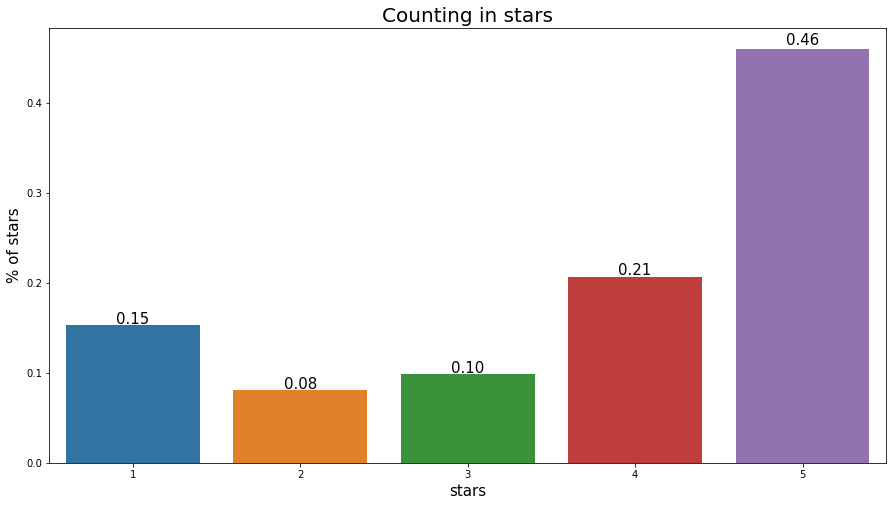

In [66]:
plot_count_col(reviews_df, col= 'stars', label_col='stars', show_val=True)

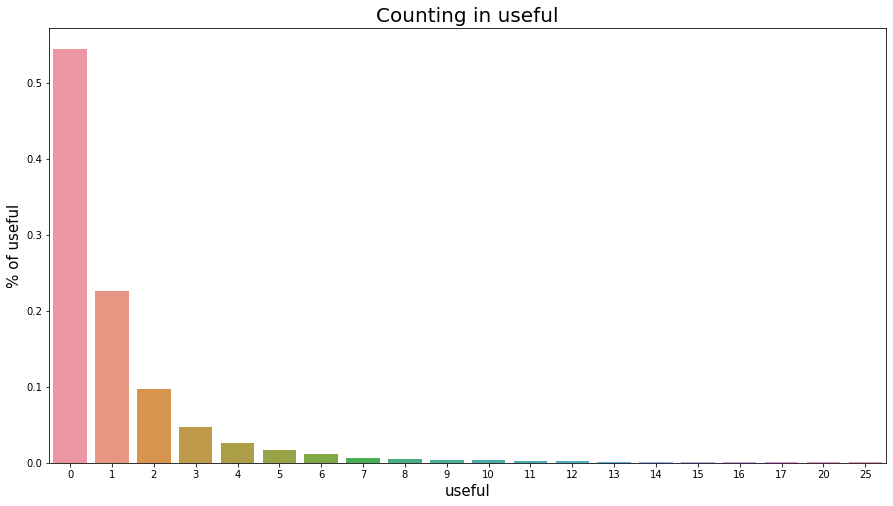

In [67]:
plot_count_col(reviews_df, col= 'useful', label_col='useful', show_val=False, top=20)

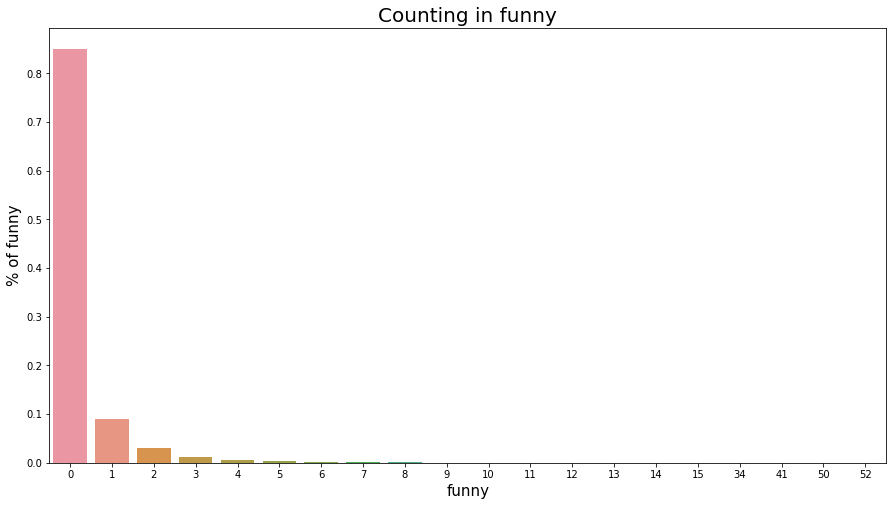

In [68]:
plot_count_col(reviews_df, col= 'funny', label_col='funny', show_val=False)

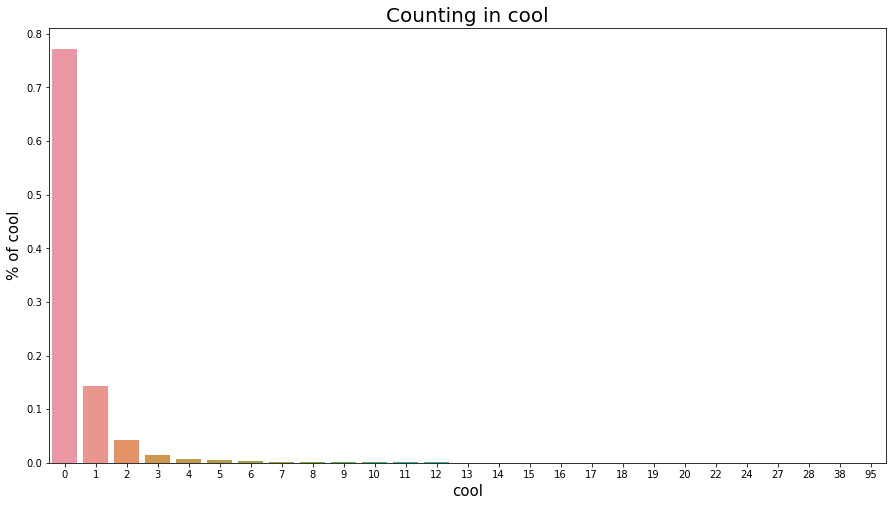

In [69]:
plot_count_col(reviews_df, col= 'cool', label_col='cool', show_val=False)

In [70]:
reviews_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

***How much reviews per user***

In [71]:
reviews_df.groupby('user_id').agg('count')

,review_id,business_id,stars,useful,funny,cool,text,date
user_id,,,,,,,,
--9jUPPYMRSnJKlOskyyDA,1,1,1,1,1,1,1,1
-02tzlpQosZ9HE85jEtV6Q,1,1,1,1,1,1,1,1
-0KrCHEsOcjJ6N4k_k1A9A,1,1,1,1,1,1,1,1
-0mrmedVkALZ0w-wROseZQ,1,1,1,1,1,1,1,1
-1XU-0De2TKEwNRmmRU2KA,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
zy3gG5D284CRO9Rsd4trFg,1,1,1,1,1,1,1,1
zzBhA0M7NNBMYoWj48h53A,1,1,1,1,1,1,1,1
zzUKixXipsKL-bzTQ2wwPw,1,1,1,1,1,1,1,1


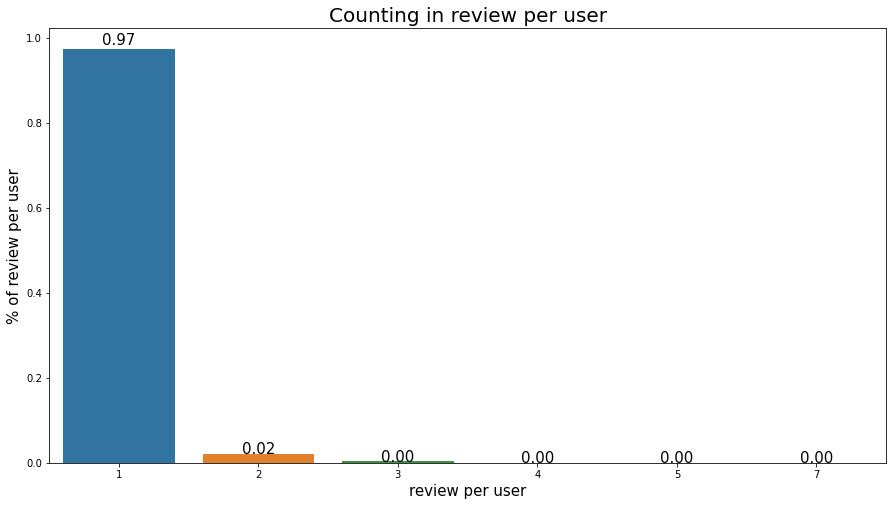

In [72]:
plot_count_col(reviews_df.groupby('user_id').agg('count'), col= 'review_id', label_col='review per user', show_val=True)

97% of users gived just 1 review.

***How much bussiness per review?***

In [73]:
reviews_df.groupby('business_id').agg('count')

,review_id,user_id,stars,useful,funny,cool,text,date
business_id,,,,,,,,
-0G_6-KFGpCpxTUlVXCMYQ,2,2,2,2,2,2,2,2
-0TffRSXXIlBYVbb5AwfTg,3,3,3,3,3,3,3,3
-0gRYq5UjMtZbELj0KHxzA,2,2,2,2,2,2,2,2
-1XSzguS6XLN-V6MVZMg2A,1,1,1,1,1,1,1,1
-1q3O9hvYmrELU39_Thbzw,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
zxIF-bnaJ-eKIsznB7yu7A,3,3,3,3,3,3,3,3
zxuVnNVAUm16Sro0dS_lmg,1,1,1,1,1,1,1,1
zyFlGv7TXKquCmXrC8cp4Q,1,1,1,1,1,1,1,1


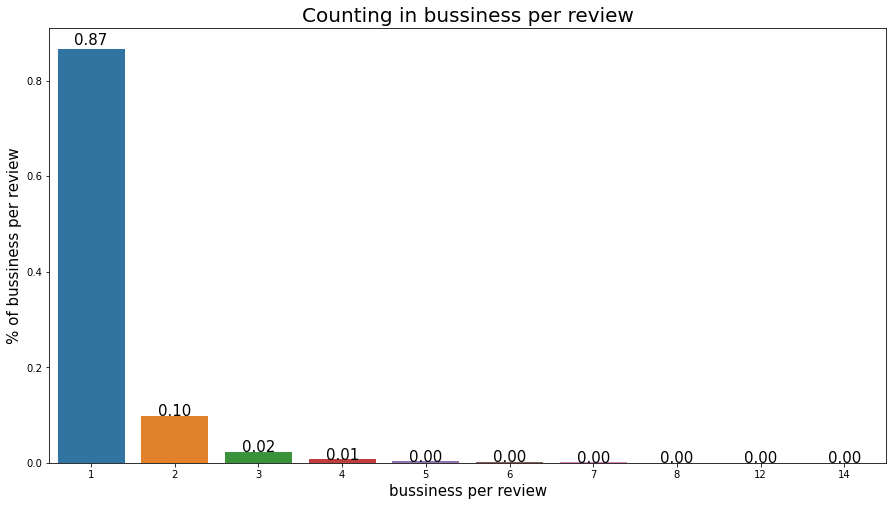

In [74]:
# Number of reviews per business
plot_count_col(reviews_df.groupby('business_id').agg('count'), col= 'review_id', label_col='bussiness per review', show_val=True)

87% of bussiness has 1 review, 2 reviews has 10% of bussienss, 3 reviews has 2 % of bussienss, 5 and more reviews has less then 1% of bussiness.

***How much review per star?***

In [75]:
reviews_df.groupby('stars').agg('count').review_id

stars
1    1534
2     813
3     987
4    2066
5    4600
Name: review_id, dtype: int64

One can see that the highest number of review is for the star equat to 5. 

In [76]:
reviews_df.groupby('stars').agg('max')[['useful', 'funny', 'cool']]

,useful,funny,cool
stars,,,
1,95,34,27
2,18,12,12
3,39,50,38
4,27,15,28
5,92,52,95


One can see that the most useful review are with stars 1 and 5. Also reviews with stars 5 are the funniest and the coolest.

Let us see if there are missing values in the reviews:

In [77]:
missing_values_table(reviews_df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Also let us see if there are review text that does not contains any text.

In [78]:
reviews_df[reviews_df.text=='']

,review_id,user_id,business_id,stars,useful,funny,cool,text,date


## Finding negative comments - sentiment analysis

In [79]:
from sklearn.model_selection import train_test_split


X = reviews_df["text"]
y = reviews_df["stars"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


In [80]:
y_train

2592    1
6078    4
1489    5
4181    4
3175    5
       ..
9372    4
7291    4
1344    4
7293    3
1289    1
Name: stars, Length: 7500, dtype: UInt8

***Binary segmentation: I will set 0 for all the data that did not give review 5 and otherwise 1 because the client is very satisfied it gived 5 as review***

In [81]:
#new_list = [<Exp1> if condition else <Exp2> if condition else <Exp3> for <item> in <iterable>]

In [291]:
yb_train = [0 if x<3 else 1 for x in y_train]
yb_test = [0 if x<3 else 1 for x in y_test]

# Define Features Bag of words

In [83]:
X

0       Some of the best Italian I've had anywhere. Ev...
1       Excellent food, wonderful nice staff. The Pho ...
2       Super slow service. Place was not busy Food wa...
3       This YMCA is top of the line!  It is only a li...
4       Walked in and got Lucy. She was wonderful. I w...
                              ...                        
9995    We had a less than pleasant experience at Simm...
9996    Ok, this is not going to be an easy review.

I...
9997    Reno in general is not like I remembered. This...
9998    first time ever i had this type of food.  man!...
9999    Customer service was great, food was absolutel...
Name: text, Length: 10000, dtype: string

***set lowercase for our data***

In [84]:
X = X.apply(lambda x: x.lower() )

In [85]:
X

0       some of the best italian i've had anywhere. ev...
1       excellent food, wonderful nice staff. the pho ...
2       super slow service. place was not busy food wa...
3       this ymca is top of the line!  it is only a li...
4       walked in and got lucy. she was wonderful. i w...
                              ...                        
9995    we had a less than pleasant experience at simm...
9996    ok, this is not going to be an easy review.\n\...
9997    reno in general is not like i remembered. this...
9998    first time ever i had this type of food.  man!...
9999    customer service was great, food was absolutel...
Name: text, Length: 10000, dtype: object

In [277]:
def preprocess_text(text):
    #text = text.lower()
    #text = word_tokenize(text)
    text = nlp(text)
    
    #tokens = [token.lemma_ for token in text if not (token.is_stop or token.is_punct)]# or token.like_num)]
    
    tokens = [token.lemma_ for token in text if
              (not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_punct
              and not token.is_space
              and not token.is_stop
              and not token.like_num
              #and not token.pos_ == "PROPN"
              )]
    
    # Initialize a stemmer
    ps = PorterStemmer()
    # and stem (remove suffix of the word)
    tokens = [ps.stem(tk) for tk in tokens]
    
    tokens = [t for t in tokens if t in wordnet.words()] # verify if the word exists in the wordnet
    
    
    text = set(tokens) - stopwords
    
    #Suppress the hours
    digit = '\d+'
    digitclock = '(\d+:\d+)'
    maybespace = '\s?'
    clock = '(AM|A\.M\.|am|a\.m\.|PM|P\.M\.|pm|p\.m\.)?'
    ptrn = digitclock+maybespace+clock + '|' + digit+maybespace+clock

    pattern = re.compile(ptrn)
    text = re.sub(pattern, '', ' '.join(text))
    
    #Suppress the rest of Digits
    #remove_digit = str.maketrans('', '', string.digits)
    #text = text.translate(remove_digit)
    
    #Suppress punctuation
    #translator = str.maketrans('', '', string.punctuation)
    #text = text.translate(translator)
    
    #Suppress newlines
    #text = text.replace('\n','')
    
    return text

In [258]:
text = 'is you hellow wold I \n\n will am be\n\n greathful 5; to see / you 1. disrespectful\n\n I you fully\n\n 2:33pm \n\n'

text = nlp(text)
tokens = [token.lemma_ for token in text if
              (not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_punct
              and not token.is_space
              and not token.is_stop
              and not token.like_num
              
              #and not token.pos_ == "PROPN"
              )]
print(tokens)
tokens = [t for t in tokens if t in wordnet.words()]
print(tokens)

#text = nlp(text)
    
#tokens = [token.lemma_ for token in text if not (token.is_stop or token.is_punct or token.like_num)]
#text = set(tokens) - stopwords
#text

['hellow', 'wold', 'greathful', 'disrespectful', 'fully', '2:33pm']
['wold', 'disrespectful', 'fully']


In [278]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)   
# Tokenize and remove stopwords
Y = X.parallel_apply(lambda x: preprocess_text(x) ) 
#tokens = [tk for tk in tokens if tk not in stopwords]
#T = X.parallel_apply(lambda x: word_tokenize(x) )

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [279]:
X

0       some of the best italian i've had anywhere. ev...
1       excellent food, wonderful nice staff. the pho ...
2       super slow service. place was not busy food wa...
3       this ymca is top of the line!  it is only a li...
4       walked in and got lucy. she was wonderful. i w...
                              ...                        
9995    we had a less than pleasant experience at simm...
9996    ok, this is not going to be an easy review.\n\...
9997    reno in general is not like i remembered. this...
9998    first time ever i had this type of food.  man!...
9999    customer service was great, food was absolutel...
Name: text, Length: 10000, dtype: object

In [280]:
Y

0                              good italian pasta scratch
1             good time nice food excel wonder staff long
2                         super cold slow food poor place
3       workout year rock ton membership great avon pl...
4                  result get wonder walk well profession
                              ...                        
9995    flip watch interact need grab nice pleasant ge...
9996    worth problem icecream portion make merlot tar...
9997    good downtown close river rival enjoy view din...
9998    desert come ask bill spinach odd want man pay ...
9999             shake custom food room save great forget
Name: text, Length: 10000, dtype: object

In [281]:
X.reset_index().loc[9995].text

'we had a less than pleasant experience at simmons today. to start, we had a hard time getting service to begin with. perhaps because we look too normal, in our mid 20s and middle class. when we were finally helped, my fiancé tried on several watches. when he went to remove a watch, the owner, jay, aggressively grabbed my fiancés wrist and forcefully flipped it over to remove the watch. a simple verbal correction on how to remove the watch would have sufficed, there was no need for physical aggression from jay. in addition, considering the current health crisis, physical involvement should be avoided at all cost. this is just one of several instances where we felt disrespected and insulted. we simply wanted to shop for something nice for each other and were met with aggression, disrespect, and belittlement. i will not support this business due to these actions and advise anyone reading this to do the same. after reading other reviews, it is clear we are not the only ones who have exper

In [282]:
Y.reset_index().loc[9995].text

'flip watch interact need grab nice pleasant get staff correct begin want current give clear health star shop owner help start wrist cost disrespect insult meet one feel review normal option today hard physic action aggress support verbal mid time go class avoid jay final read look'

In [292]:
vectorizers = [CountVectorizer(), TfidfVectorizer(), 
    """
               CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizers['stopwords'],
    
    )"""
              ]

In [293]:
v = vectorizers[0]
X_v = v.fit_transform(Y)
words_count = pd.DataFrame(
        data = np.column_stack((v.get_feature_names(), X_v.sum(axis=0).tolist()[0])) ,
    columns=['word', 'freq']
)

/opt/anaconda3/envs/oc6/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [285]:
syns = wordnet.synsets("aaa")
syns[0].definition()

'an aneurysm of the abdominal aorta associated with old age and hypertension'

In [286]:
'aaa' in wordnet.words()

True

In [294]:
words_count.head()

,word,freq
0,aaa,2
1,aaron,1
2,ab,6
3,aback,6
4,abandon,4


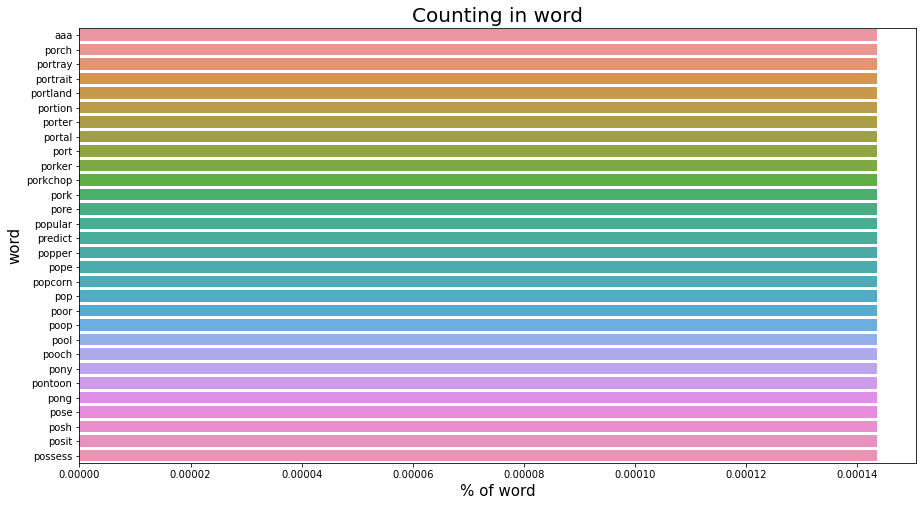

In [290]:
plot_count_col(words_count, col='word', label_col='word', top=30, show_val = False, on_x=False)

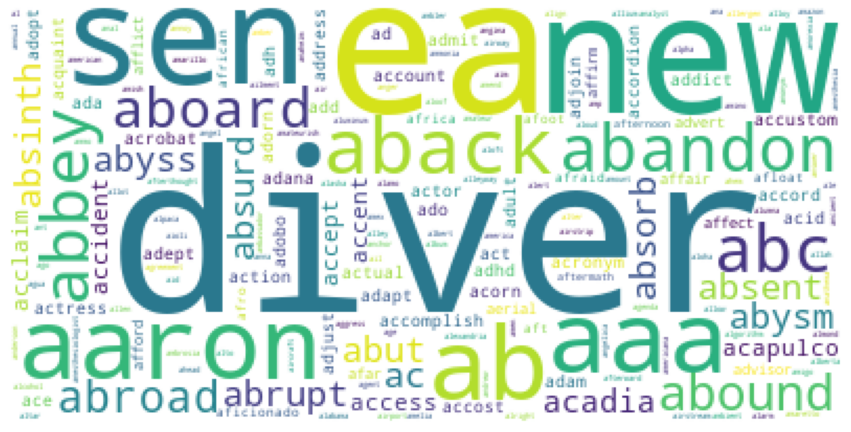

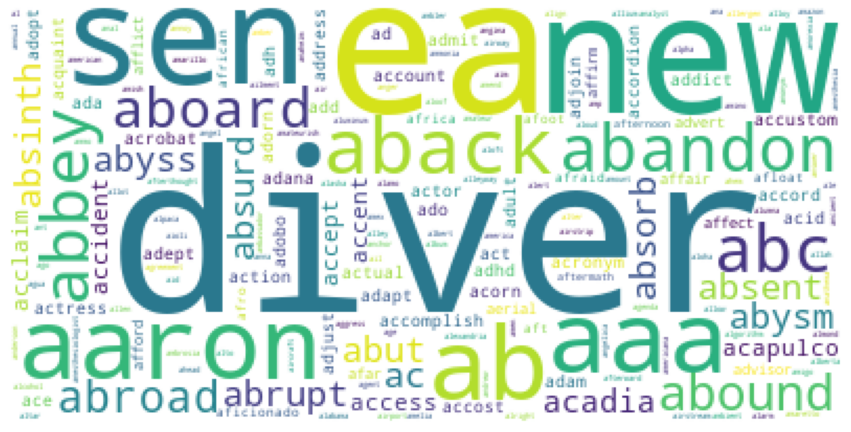

In [289]:
plot_words(words_count, col='word', height = 15, wieght = 10)

# Photos dataset

In [6]:
photos_df = pd.DataFrame()
with pd.read_json("data/yelp_photos/photos.json",
    chunksize=500 * 1000,
    lines=True,
) as json_reader:
    # Load data in chunks
    for chunk in json_reader:
        photos_df = photos_df.append(chunk)
        logger.info(f"Loaded {len(photos_df)} photos")
logger.info(f">>> OK : {len(photos_df)} photos loaded from JSON file.")

# Reduce memory usage
photos_df = reduce_dataframe_memory_usage(photos_df)

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_43185/1474923334.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  photos_df = photos_df.append(chunk)
INFO:__main__:Loaded 200100 photos
INFO:__main__:>>> OK : 200100 photos loaded from JSON file.
INFO:root:Memory usage of dataframe is 6 MB
INFO:root:Memory usage after optimization is 4 MB
INFO:root:Decreased by 22 %


In [8]:
if PHOTO_SAMPLE_SIZE > 0:
    sampled_photos_df = pd.DataFrame()
    for label in photos_df.label.unique():
        sampled_photos_df = sampled_photos_df.append(
            photos_df[photos_df.label == label].sample(
                int(PHOTO_SAMPLE_SIZE / (len(photos_df.label.unique()))),
                random_state=0, replace=True
            )
        )
else:
    sampled_photos_df = photos_df

sampled_photos_df.describe(include="all")

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_43185/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_photos_df = sampled_photos_df.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_43185/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_photos_df = sampled_photos_df.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_43185/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_photos_df = sampled_photos_df.append(
/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_43185/1473375866.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,photo_id,business_id,caption,label
count,20000,20000,20000,20000
unique,16421,10465,6723,5
top,VISAuSLU8kB79k4wBgj4kA,FEXhWNCMkv22qG04E83Qjg,,drink
freq,11,61,10404,4000


In [9]:
photos_df.shape

(200100, 4)

In [10]:
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


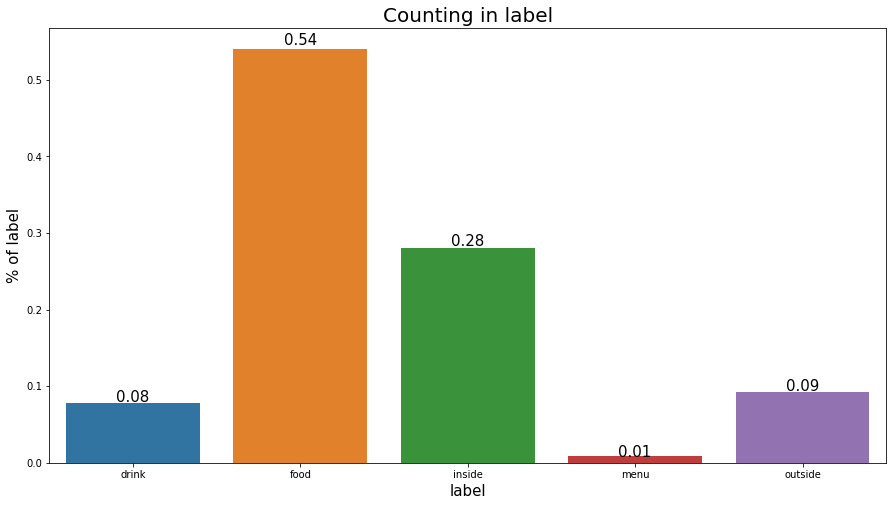

In [14]:
plot_count_col(photos_df, col='label', label_col='label', show_val = True, on_x=True)

In this part of project we are predicting the label of the photos. But before this we need to proceed the extraction of the features in our images datasets:
 - colors : RGB, HSV and LAB histograms of patches of the image
     - shapes : gradient histograms of patches of the image (HOG features)
     - keypoints : corners of objects detected in the image (ORB features)
     - define a vocabulary of "visual-words" : clusters of visual features that are similar to each other
 - represent each photo as a vector of visual-words (bag of visual-words representation)
 - train a classifier to predict the label of the photo based on the bag of visual-words representation

# Visual features extraction
color features :
randomly pick 200 20x20 patches of the image

for each patch :
compute the RGB, HSV and LAB histograms of the patch with 5-bins per channel
=> 3 vectors of size 5**3 = 125
=> 600 vectors of size 125 per image
shape features :
compute the Histogram of Gradients (HOG) of the image with :
blocks of 2x2 cells
cells of 12x12 pixels
9 bins of gradient orientation per cell
=> for an image of 240x480 : 19x39x4 = 2964 vectors of size 9
keypoints features :
compute the 200 first ORB keypoints of the image
=> 200 vectors of size 32 per image

In [17]:
import cv2 as cv
from skimage.feature import hog
from sklearn.feature_extraction.image import extract_patches_2d

In [18]:
photos_features_df = pd.DataFrame()
for photo in photos_df.itertuples():
    # Load image
    img_path = os.path.join("/data/yelp_photos/photos", f"{photo.photo_id}.jpg")
    img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # COLOR Features
    color_descriptors = []
    for patch in extract_patches_2d(
        img,
        patch_size=(20, 20),
        max_patches=200,
        random_state=1,
    ):
        color_descriptors.append(
            cv.calcHist(
                [
                    cv.cvtColor(patch, cv.COLOR_BGR2RGB),
                    cv.cvtColor(patch, cv.COLOR_BGR2HSV),
                    cv.cvtColor(patch, cv.COLOR_BGR2LAB),
                ],
                [0, 1, 2],
                None,
                [5, 5, 5],
                [0, 256, 0, 256, 0, 256],
            ).flatten()
        )

    # HOG Features
    n_orientations = 9
    hog_features = hog(
        img_gray,
        pixels_per_cell=(10, 10),
        cells_per_block=(2, 2),
        orientations=n_orientations,
        transform_sqrt=True,
    )
    hog_descriptors = [
        hog_features[i : i + n_orientations]
        for i in range(0, len(hog_features), n_orientations)
    ]

    # ORB Features
    orb = cv.ORB_create(nfeatures=200)
    orb_keypoints = orb.detect(img_gray, None)
    orb_keypoints, orb_descriptors = orb.compute(img_gray, orb_keypoints)

    photos_features_df = photos_features_df.append(
        {
            "file_name": photo.photo_id,
            "label": photo.label,
            "color_descriptors": color_descriptors,
            "hog_descriptors": hog_descriptors,
            "orb_keypoints": orb_keypoints,
            "orb_descriptors": orb_descriptors,
        },
        ignore_index=True,
    )

photos_features_df.dropna(inplace=True)

[ WARN:0@608.576] global /Users/runner/miniforge3/conda-bld/libopencv_1657598003291/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/data/yelp_photos/photos/zsvj7vloL4L5jhYyPIuVwg.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1657598003291/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
photos_features_df